<a href="https://colab.research.google.com/github/gustavovazquez/ML/blob/main/ML_Optimizaci%C3%B3n_de_hiperpar%C3%A1metros_DT_Breast_cancer_(clasificaci%C3%B3n).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sobreajuste sin tuning de hiperparámetros - Efecto y solución

Este cuaderno busca ilustrar un fenómeno clásico en Machine Learning: el **sobreajuste** de modelos muy flexibles
cuando no se controlan sus hiperparámetros, y cómo técnicas como la **validación cruzada** y el ajuste de hiperparámetros
permiten mejorar la capacidad de generalización.

El ejemplo se basa en el dataset **Breast Cancer Wisconsin (Diagnostic)** incluido en scikit-learn.
Es un dataset de clasificación binaria con 30 características numéricas que describen medidas obtenidas de imágenes de tumores de mama.



## Importación de librerías

Comenzamos importando las librerías necesarias para el análisis:
- `numpy` y `pandas` para manejo de datos.
- `matplotlib` para visualización.
- `sklearn.datasets` para cargar el dataset.
- `sklearn.tree` para entrenar árboles de decisión.
- `sklearn.model_selection` para dividir datos, validación cruzada y búsqueda de hiperparámetros.
- `sklearn.metrics` para medir desempeño del modelo.


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV, validation_curve
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, precision_score, accuracy_score, classification_report, confusion_matrix




## Configuración del entorno

Definimos una semilla aleatoria para garantizar reproducibilidad de los resultados y
ajustamos parámetros básicos de visualización para los gráficos.


In [ ]:

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## Carga y descripción de los datos

El dataset **Breast Cancer Wisconsin** contiene 569 observaciones y 30 características numéricas.
La variable objetivo indica si un tumor es **maligno** (0) o **benigno** (1).  
Es un conjunto de datos clásico para probar algoritmos de clasificación binaria.

Dividiremos el dataset en un conjunto de entrenamiento (80%) y un conjunto de prueba (20%).
El conjunto de entrenamiento se utilizará para ajustar y validar el modelo,
mientras que el conjunto de prueba permitirá evaluar su capacidad de generalización.


In [ ]:

cancer = load_breast_cancer()
X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = pd.Series(cancer.target, name="target")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
X.shape, X_train.shape, X_test.shape


((569, 30), (455, 30), (114, 30))


## Árbol sin tuning de hiperparámetros

Cuando entrenamos un **árbol de decisión sin restricciones** (dejando que crezca libremente),
el modelo tiende a memorizar el conjunto de entrenamiento. Esto se traduce en una exactitud
casi perfecta sobre los datos de entrenamiento, ya que el árbol crea reglas muy específicas
que clasifican correctamente cada observación.

**OBS: Por defecto scikitlearn construye el árbol de decisión sin restricciones!**

El problema es que este mismo nivel de detalle hace que el modelo **pierda capacidad de generalizar**
a datos nuevos. En el conjunto de prueba, donde aparecen observaciones no vistas,
la exactitud suele ser menor. Este fenómeno se conoce como **sobreajuste (overfitting)**:
el modelo se adapta tanto al entrenamiento que no logra generalizar bien en datos no vistos.

En esta sección entrenaremos un árbol por defecto y veremos cómo se comporta en *train* y *test*,
además de inspeccionar su profundidad y número de hojas (como indicador de complejidad).


In [ ]:

tree_default = DecisionTreeClassifier(criterion='entropy',  random_state=RANDOM_STATE)
tree_default.fit(X_train, y_train)

y_pred_train = tree_default.predict(X_train)
y_pred_test = tree_default.predict(X_test)

acc_train = accuracy_score(y_train, y_pred_train)
acc_test  = accuracy_score(y_test,  y_pred_test)

print(f"Accuracy (train): {acc_train:.3f}")
print(f"Accuracy (test) : {acc_test:.3f}")
print(f"Profundidad: {tree_default.get_depth()} | Hojas: {tree_default.get_n_leaves()}")



Accuracy (train): 1.000
Accuracy (test) : 0.912
Profundidad: 6 | Hojas: 16


In [ ]:
# show generated tree
print(export_text(tree_default, feature_names=list(X.columns)))

|--- worst radius <= 16.80
|   |--- worst concave points <= 0.14
|   |   |--- area error <= 38.60
|   |   |   |--- worst texture <= 29.98
|   |   |   |   |--- class: 1
|   |   |   |--- worst texture >  29.98
|   |   |   |   |--- worst concave points <= 0.09
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- worst concave points >  0.09
|   |   |   |   |   |--- mean concave points <= 0.03
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- mean concave points >  0.03
|   |   |   |   |   |   |--- class: 1
|   |   |--- area error >  38.60
|   |   |   |--- texture error <= 2.01
|   |   |   |   |--- class: 1
|   |   |   |--- texture error >  2.01
|   |   |   |   |--- texture error <= 2.43
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- texture error >  2.43
|   |   |   |   |   |--- class: 1
|   |--- worst concave points >  0.14
|   |   |--- worst texture <= 27.39
|   |   |   |--- worst concave points <= 0.18
|   |   |   |   |--- worst area <= 725.30
|   |   |   |   |  


### Variabilidad con múltiples particiones

Para asegurarnos de que el comportamiento observado no es producto de una única división *train/test*,
repetimos el entrenamiento con **30 particiones diferentes** utilizando `ShuffleSplit`.
Esto nos permitirá calcular la exactitud media y su desviación estándar tanto en entrenamiento como en prueba.

De este modo, podemos visualizar con mayor claridad la diferencia entre el rendimiento del árbol en los datos que ya conoce
y en datos completamente nuevos.


In [ ]:

cv = ShuffleSplit(n_splits=30, test_size=0.2, random_state=RANDOM_STATE)
accs_train, accs_test = [], []

for tr_idx, te_idx in cv.split(X, y):
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx],  y.iloc[te_idx]

    clf = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE)
    clf.fit(X_tr, y_tr)
    accs_train.append(accuracy_score(y_tr, clf.predict(X_tr)))
    accs_test.append(accuracy_score(y_te, clf.predict(X_te)))

mean_train, std_train = np.mean(accs_train), np.std(accs_train)
mean_test, std_test = np.mean(accs_test), np.std(accs_test)
mean_train, mean_test, std_train, std_test

(np.float64(1.0),
 np.float64(0.9359649122807016),
 np.float64(0.0),
 np.float64(0.023878346647045964))

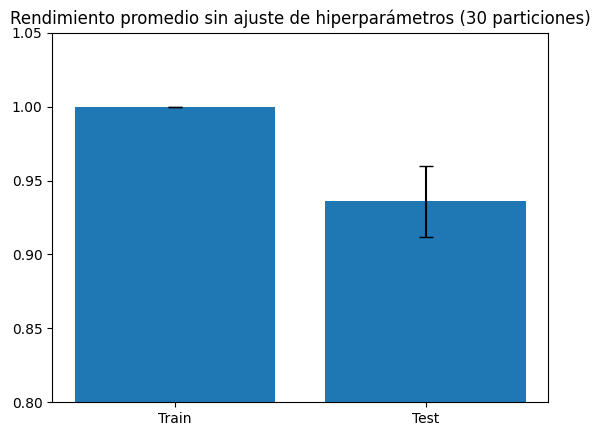

In [ ]:

plt.bar(["Train", "Test"], [mean_train, mean_test], yerr=[std_train, std_test], capsize=5)
plt.ylim(0.8, 1.05)
plt.title("Rendimiento promedio sin ajuste de hiperparámetros (30 particiones)")
plt.show()



## Curva de validación para `max_depth`

Una forma de entender el sobreajuste es limitar manualmente la **profundidad máxima del árbol** (`max_depth`).
Si el árbol es muy profundo, memoriza el entrenamiento y generaliza peor.
Si es muy poco profundo, puede quedarse corto para capturar patrones importantes (**subajuste/underfitting**).

La **curva de validación** permite observar cómo cambian las métricas de entrenamiento y validación
al variar `max_depth`. En términos prácticos, si solo optimizáramos `max_depth` el punto óptimo sería tener un árbol con la profundidad correspondiente al máximo valor de la métrica usada (ese punto indica el mejor equilibrio entre complejidad y capacidad de generalización).


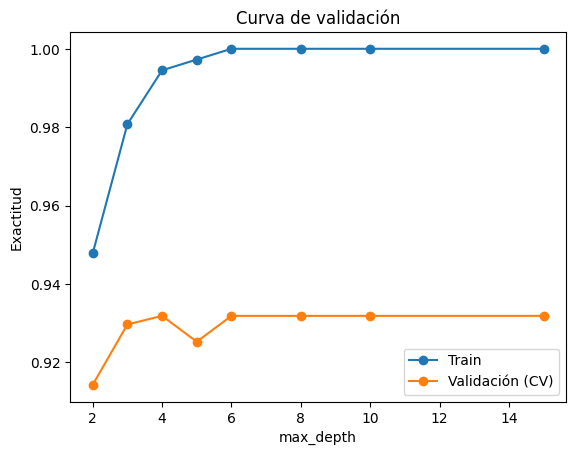

In [ ]:

depth_values = [2, 3, 4, 5, 6, 8, 10, 15]
train_scores, valid_scores = validation_curve(
    DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE),
    X_train, y_train,
    param_name="max_depth",
    param_range=depth_values,
    cv=5,
    scoring="accuracy"
)
plt.plot(depth_values, train_scores.mean(axis=1), marker="o", label="Train")
plt.plot(depth_values, valid_scores.mean(axis=1), marker="o", label="Validación (CV)")
plt.xlabel("max_depth")
plt.ylabel("Exactitud")
plt.title("Curva de validación")
plt.legend()
plt.show()



## Ajuste de hiperparámetros con GridSearchCV

En lugar de elegir manualmente los hiperparámetros, utilizamos **GridSearchCV**,
que prueba combinaciones de valores y selecciona la que maximiza la exactitud promedio en validación cruzada.

Los hiperparámetros que ajustaremos son:

- `max_depth`: profundidad máxima del árbol.
- `min_samples_leaf`: número mínimo de muestras por hoja.
- `min_samples_split`: número mínimo de muestras para dividir un nodo.
- `ccp_alpha`: parámetro de complejidad utilizado en pruning.



In [ ]:

param_grid = {
    "max_depth": [None, 3, 4, 5, 6, 8, 10],
    "min_samples_leaf": [1, 2, 3, 4],
    "min_samples_split": [2, 3, 4],
    "ccp_alpha": [0.0, 1e-4, 1e-3]
}

grid = GridSearchCV(
    DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE),
    param_grid=param_grid, cv=5, scoring="accuracy"
)
grid.fit(X_train, y_train)
grid.best_params_, grid.best_score_


({'ccp_alpha': 0.0,
  'max_depth': 4,
  'min_samples_leaf': 2,
  'min_samples_split': 2},
 np.float64(0.9340659340659341))

In [ ]:
# genera codigo para mostrar una grilla con las diferentes combinaciones de hiperparametros y su rendimiento. ordena por rendimiento
results = pd.DataFrame(grid.cv_results_)
results = results.sort_values(by='mean_test_score', ascending=False)
display(results[[
    "param_max_depth",
    "param_min_samples_leaf",
#    "param_min_samples_split",
#    "param_ccp_alpha",
    "mean_test_score",
    "std_test_score",
]].head(10))


,param_max_depth,param_min_samples_leaf,mean_test_score,std_test_score
27,4,2,0.934066,0.021978
28,4,2,0.934066,0.021978
29,4,2,0.934066,0.021978
113,4,2,0.934066,0.021978
111,4,2,0.934066,0.021978
112,4,2,0.934066,0.021978
197,4,2,0.934066,0.021978
196,4,2,0.934066,0.021978
195,4,2,0.934066,0.021978
49,6,1,0.931868,0.012815


In [ ]:
# Cómo obtenemos de forma automática los hiperparámetros óptimos?
best_tree = grid.best_estimator_
acc_train_best = accuracy_score(y_train, best_tree.predict(X_train))
acc_test_best  = accuracy_score(y_test,  best_tree.predict(X_test))
acc_train_best, acc_test_best, best_tree.get_depth()


(0.9846153846153847, 0.9385964912280702, 4)


## Comparación final

Ahora comparamos directamente el desempeño de:

- Árbol sin ajuste de hiperparámetros (por defecto).
- Árbol ajustado con GridSearchCV.

El objetivo es evidenciar cómo el modelo ajustado logra mantener una alta exactitud en prueba
sin necesidad de memorizar el entrenamiento, logrando un **equilibrio train/test** mucho más saludable.


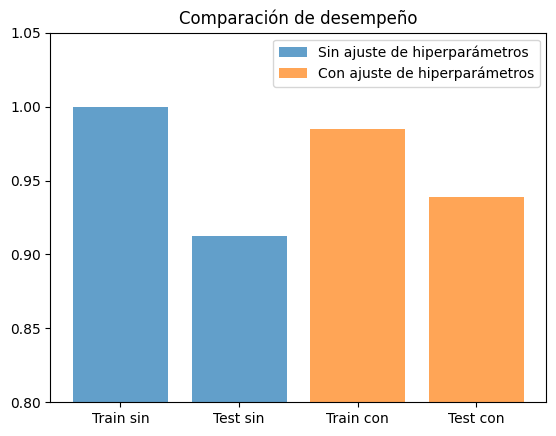

In [ ]:

plt.bar(["Train sin", "Test sin"], [acc_train, acc_test], label="Sin ajuste de hiperparámetros", alpha=0.7)
plt.bar(["Train con", "Test con"], [acc_train_best, acc_test_best], label="Con ajuste de hiperparámetros", alpha=0.7)
plt.ylim(0.8, 1.05)
plt.legend()
plt.title("Comparación de desempeño")
plt.show()



## Conclusiones

- Un árbol de decisión (como cualquier modelo de ML) **sin restricciones** logra exactitud casi perfecta en entrenamiento,
pero generaliza peor a datos nuevos → **sobreajuste**.
- Limitar la profundidad del árbol y otros parámetros de complejidad permite mejorar la **generalización**.
- La **curva de validación** muestra de forma clara la diferencia entre entrenar demasiado (sobreajuste)
y entrenar poco (subajuste).
- Usar **GridSearchCV** es una estrategia práctica y sistemática para encontrar hiperparámetros
que logren un equilibrio óptimo.
- Existen otros métodos como por ejemplo Optuna (framework  para optimizar hiperparámetros de manera eficiente y automática, a diferencia de GridSearchCV, que evalúa exhaustivamente una grilla prefijada)



In [ ]:
# mostrar arbol generado en best_tree
print(export_text(best_tree, feature_names=list(X.columns)))

|--- worst radius <= 16.80
|   |--- worst concave points <= 0.14
|   |   |--- area error <= 38.60
|   |   |   |--- worst texture <= 29.98
|   |   |   |   |--- class: 1
|   |   |   |--- worst texture >  29.98
|   |   |   |   |--- class: 1
|   |   |--- area error >  38.60
|   |   |   |--- texture error <= 2.01
|   |   |   |   |--- class: 1
|   |   |   |--- texture error >  2.01
|   |   |   |   |--- class: 0
|   |--- worst concave points >  0.14
|   |   |--- worst texture <= 27.39
|   |   |   |--- worst concave points <= 0.18
|   |   |   |   |--- class: 1
|   |   |   |--- worst concave points >  0.18
|   |   |   |   |--- class: 0
|   |   |--- worst texture >  27.39
|   |   |   |--- class: 0
|--- worst radius >  16.80
|   |--- texture error <= 0.47
|   |   |--- class: 1
|   |--- texture error >  0.47
|   |   |--- worst concavity <= 0.19
|   |   |   |--- mean texture <= 21.35
|   |   |   |   |--- class: 1
|   |   |   |--- mean texture >  21.35
|   |   |   |   |--- class: 0
|   |   |--- wors

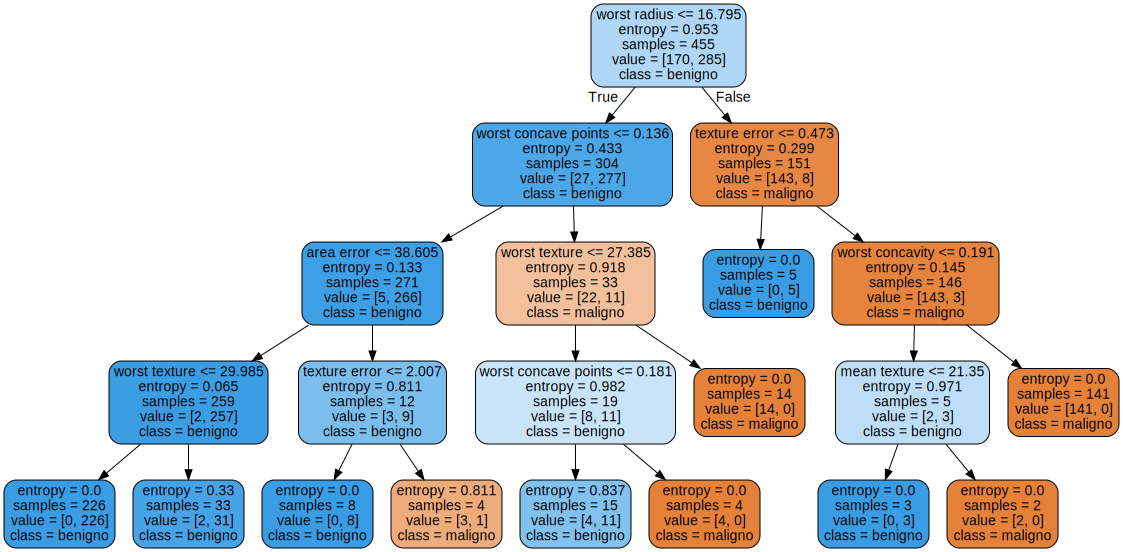

In [ ]:
# mostrar imagen de arbol generado en best_tree
from sklearn.tree import export_graphviz
import graphviz
dot_data = export_graphviz(best_tree, out_file=None,
                           feature_names=list(X.columns),
                           class_names=["maligno", "benigno"],
                           filled=True, rounded=True,
                           )
graph = graphviz.Source(dot_data)
graph.render("tree")
graph
